In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('max_colwidth', None)
import re
import csv
from skimpy import skim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import joblib

In [2]:
data = pd.read_csv('laptop_details.csv')
data.head()

,Product,Rating,MRP,Feature
0,Lenovo IdeaPad 3 Core i3 11th Gen - (8 GB/256 GB SSD/Windows 11 Home) 14ITL05 Thin and Light Laptop,4.2,"₹36,990",Intel Core i3 Processor (11th Gen)8 GB DDR4 RAM64 bit Windows 11 Operating System256 GB SSD35.56 cm (14 inch) DisplayOffice Home and Student 20212 Year Onsite�Warranty
1,Lenovo IdeaPad 3 Core i3 11th Gen - (8 GB/512 GB SSD/Windows 11 Home) 82H801L7IN | 82H802FJIN | 82H802...,4.2,"₹39,990",Intel Core i3 Processor (11th Gen)8 GB DDR4 RAM64 bit Windows 11 Operating System512 GB SSD39.62 cm (15.6 inch) DisplayOffice Home and Student 20212 Year Onsite�Warranty
2,ASUS VivoBook 15 (2022) Core i3 10th Gen - (8 GB/512 GB SSD/Windows 11 Home) X515JA-EJ362WS | X515JA-E...,4.3,"₹32,990",Intel Core i3 Processor (10th Gen)8 GB DDR4 RAM64 bit Windows 11 Operating System512 GB SSD39.62 cm (15.6 inch) DisplayOffice Home and Student 20211 Year Onsite Warranty
3,HP Pavilion Ryzen 5 Hexa Core AMD R5-5600H - (8 GB/512 GB SSD/Windows 10/4 GB Graphics/NVIDIA GeForce ...,4.4,"₹49,990","AMD Ryzen 5 Hexa Core Processor8 GB DDR4 RAM64 bit Windows 10 Operating System512 GB SSD39.62 cm (15.6 inch) DisplayHP Documentation, HP e-service, HP BIOS Recovery, HP SSRM, HP Smart, HP Jumpstarts1 Year Onsite Warranty"
4,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/512 GB SSD/Windows 11 Home/4 GB Graphics/NVIDIA GeForce G...,4.4,"₹49,990",Intel Core i5 Processor (10th Gen)8 GB DDR4 RAMWindows 11 Operating System512 GB SSD39.62 cm (15.6 inch) Display1 Year Onsite Warranty


In [3]:
df = data.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Product  720 non-null    object 
 1   Rating   581 non-null    float64
 2   MRP      720 non-null    object 
 3   Feature  720 non-null    object 
dtypes: float64(1), object(3)
memory usage: 22.6+ KB


In [5]:
df.isna().sum()

Product      0
Rating     139
MRP          0
Feature      0
dtype: int64

## Feature Engineering
Since, this is mainly a text data, we will use the regex function to clean the data.
We will create new features such as Ram size, Ram type, Processor, Storage type, os from the poducts and feature table

In [6]:
def extract_features(row):
    product = row['Product']
    feature = row['Feature']
    
    ram_size = re.findall(r'(\d+) ?(?:GB|TB)', feature)
    ram_size = ram_size[0] + ' GB' if ram_size else None
    
    ram_type = re.findall(r'(?:LP)?DDR\d\S*|Unified\sMemory', feature)
    ram_type = ram_type[0] if ram_type else None
    
    processor = re.findall(r'(?:AMD|Intel|M1|Qualcomm|Apple)[\s\w]+Processor', feature)
    processor = processor[0] if processor else None

    storage = re.findall(r'[\d]+\s(?:GB|TB)\s(?:HDD|SSD|EMMC)', product)
    storage = storage[0] if storage else None
    
    os = re.findall(r'(Windows (?:10|11)|Mac OS|Linux|DOS|Chrome)[\s\w]*Operating System', feature)
    os = os[0] if os else None

    display = re.findall(r'\d+(?:\.\d+)?\s*(?:cm|inch)\s*(?:\(|:)?\s*\d+(?:\.\d+)?\s*(?:cm|inch)?', feature)
    display = display[0] if display else None
    
    brand = re.findall(r'^\w+', product)
    brand = brand[0] if brand else None
    
    return pd.Series([ram_size, ram_type, processor, storage, os, display, brand], 
                     index=['Ram Size', 'Ram Type', 'Processor', 'Storage', 'OS', 'Display', 'Brand'])

df[['Ram Size', 'Ram Type', 'Processor', 'Storage', 'OS', 'Display', 'Brand']] = df.apply(extract_features, axis=1)

In [7]:
df.isna().sum()

Product        0
Rating       139
MRP            0
Feature        0
Ram Size       0
Ram Type       0
Processor      0
Storage        0
OS             0
Display        0
Brand          0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Product    720 non-null    object 
 1   Rating     581 non-null    float64
 2   MRP        720 non-null    object 
 3   Feature    720 non-null    object 
 4   Ram Size   720 non-null    object 
 5   Ram Type   720 non-null    object 
 6   Processor  720 non-null    object 
 7   Storage    720 non-null    object 
 8   OS         720 non-null    object 
 9   Display    720 non-null    object 
 10  Brand      720 non-null    object 
dtypes: float64(1), object(10)
memory usage: 62.0+ KB


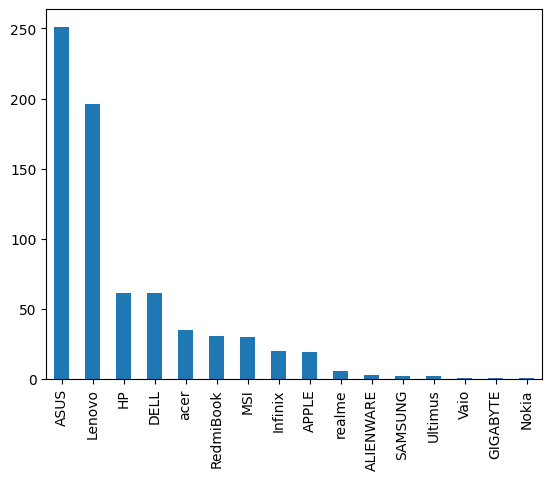

In [9]:
df.Brand.value_counts().plot(kind='bar');

The above figure shows that for the present dataset, brand isn't a good feature that will predict the laptop price. It will be prone to bias. Therefore, it will be dropped. Including ratings which have large missing values and may not be really influence the price of laptop. Finally, we drop the Product and Feature columns since we have extracted the necessary features for our analysis. 

## Data Cleaning

In [10]:
## Data Cleaning
df.MRP = df.MRP.apply(lambda x : x.replace('₹', '').replace(',', '')).astype(float)
df.drop(df.columns[[0, 1, 3, 10]], axis=1, inplace=True)
df.head(2)

,MRP,Ram Size,Ram Type,Processor,Storage,OS,Display
0,36990.0,8 GB,DDR4,Intel Core i3 Processor,256 GB SSD,Windows 11,35.56 cm (14 inch
1,39990.0,8 GB,DDR4,Intel Core i3 Processor,512 GB SSD,Windows 11,39.62 cm (15.6 inch


In [11]:
df['Ram Type'] = df['Ram Type'].str.replace('DDR4,','DDR4')

In [12]:
## Rename the column names
new_column_names = {'MRP': 'price',
                    'Ram Size': 'ram_size',
                    'Ram Type': 'ram_type',
                    'Processor': 'processor',
                    'Storage': 'storage',
                    'OS': 'os_type',
                    'Display': 'display',
                    'Brand': 'brand'}
df = df.rename(columns=new_column_names)

In [13]:
# this extracts the last word in each value, as the storage type
df['storage_type'] = df.storage.apply(lambda x: x.split()[-1])

# using the split function, join the first 2 element
df['storage'] = df.storage.apply(lambda x: " ".join(x.split()[:2]))

In [14]:
# Define the dictionaries for label encoding
ram_size_dict = {
    '4 GB':0,
    '8 GB':1,
    '16 GB':2,
    '32 GB':3,
    '128 GB':4
}

ram_type_dict = {
    'LPDDR3':0,
    'Unified Memory':1,
    'LPDDR4':2,
    'DDR4':3,
    'LPDDR4X':4,
    'LPDDR5':5,
    'DDR5':6
}

processor_dict = {
    'AMD Athlon Dual Core Processor':0,
    'AMD Dual Core Processor':1,
    'Intel Celeron Dual Core Processor':2,
    'Intel Celeron Quad Core Processor':3,
    'Intel Pentium Quad Core Processor':4,
    'Intel Pentium Silver Processor':5,
    'AMD Ryzen 3 Dual Core Processor':6,
    'AMD Ryzen 3 Quad Core Processor':7,
    'AMD Ryzen 3 Hexa Core Processor':8,
    'AMD Ryzen 5 Dual Core Processor':9,
    'AMD Ryzen 5 Quad Core Processor':10,
    'AMD Ryzen 5 Hexa Core Processor':11,
    'AMD Ryzen 7 Quad Core Processor':12,
    'AMD Ryzen 7 Octa Core Processor':13,
    'AMD Ryzen 9 Octa Core Processor':14,
    'Apple M1 Processor':15,
    'Apple M1 Pro Processor':16,
    'Apple M1 Max Processor':17,
    'Apple M2 Processor':18,
    'Intel Core i3 Processor':19,
    'Intel OptaneIntel Core i3 Processor':20,
    'Intel Core i5 Processor':21,
    'Intel Evo Core i5 Processor':22,
    'Intel Core i7 Processor':23,
    'Intel Core i9 Processor':24,
    'Qualcomm Snapdragon 7c Gen 2 Processor':25
}

storage = [
    '32 GB',
    '64 GB',
    '128 GB',
    '256 GB',
    '512 GB',
    '1 TB',
    '2 TB'
]

storage_dict = {s: i for i, s in enumerate(storage)}

storage_type_dict = {
    'EMMC':0,
    'HDD':1,
    'SSD':2
}

column_dicts = {
    'ram_size':ram_size_dict,
    'ram_type':ram_type_dict,
    'processor':processor_dict,
    'storage':storage_dict,
    'storage_type':storage_type_dict
}

# Map the categorical columns using label encoding
categorical_columns = ['ram_size', 'ram_type', 'processor', 'storage', 'storage_type']

for col in categorical_columns:
    df[col] = df[col].map(column_dicts.get(col, lambda x: x))
    
laptopdict = [ram_size_dict, ram_type_dict, processor_dict, storage_dict, storage_type_dict]

# Encode the label encoded categorical columns using label encoding
le2 = LabelEncoder()

for column in ['os_type', 'display']:
    encoded = le2.fit_transform(df[column])
    df.drop(column, axis=1, inplace=True)
    df[column] = encoded
    col_dict = dict(zip(range(len(le2.classes_)), le2.classes_))
    laptopdict.append(col_dict)

In [15]:
laptopdict

[{'4 GB': 0, '8 GB': 1, '16 GB': 2, '32 GB': 3, '128 GB': 4},
 {'LPDDR3': 0,
  'Unified Memory': 1,
  'LPDDR4': 2,
  'DDR4': 3,
  'LPDDR4X': 4,
  'LPDDR5': 5,
  'DDR5': 6},
 {'AMD Athlon Dual Core Processor': 0,
  'AMD Dual Core Processor': 1,
  'Intel Celeron Dual Core Processor': 2,
  'Intel Celeron Quad Core Processor': 3,
  'Intel Pentium Quad Core Processor': 4,
  'Intel Pentium Silver Processor': 5,
  'AMD Ryzen 3 Dual Core Processor': 6,
  'AMD Ryzen 3 Quad Core Processor': 7,
  'AMD Ryzen 3 Hexa Core Processor': 8,
  'AMD Ryzen 5 Dual Core Processor': 9,
  'AMD Ryzen 5 Quad Core Processor': 10,
  'AMD Ryzen 5 Hexa Core Processor': 11,
  'AMD Ryzen 7 Quad Core Processor': 12,
  'AMD Ryzen 7 Octa Core Processor': 13,
  'AMD Ryzen 9 Octa Core Processor': 14,
  'Apple M1 Processor': 15,
  'Apple M1 Pro Processor': 16,
  'Apple M1 Max Processor': 17,
  'Apple M2 Processor': 18,
  'Intel Core i3 Processor': 19,
  'Intel OptaneIntel Core i3 Processor': 20,
  'Intel Core i5 Processor':

In [16]:
df.head(3)

,price,ram_size,ram_type,processor,storage,storage_type,os_type,display
0,36990.0,1,3,19,3,2,4,10
1,39990.0,1,3,19,4,2,4,16
2,32990.0,1,3,19,4,2,4,16


In [17]:
df.dtypes

price           float64
ram_size          int64
ram_type          int64
processor         int64
storage           int64
storage_type      int64
os_type           int32
display           int32
dtype: object

## Visualization

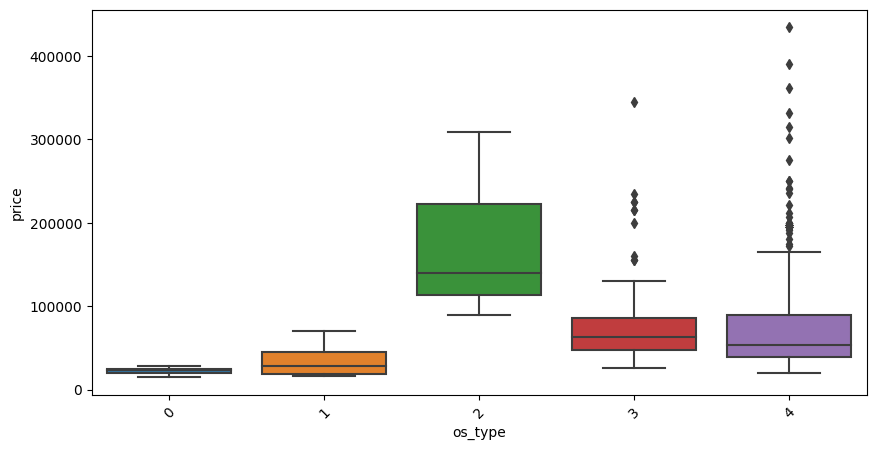

In [18]:
plt.figure(figsize=(10, 5))
ax = sns.boxplot(x = df.os_type, y = df.price)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

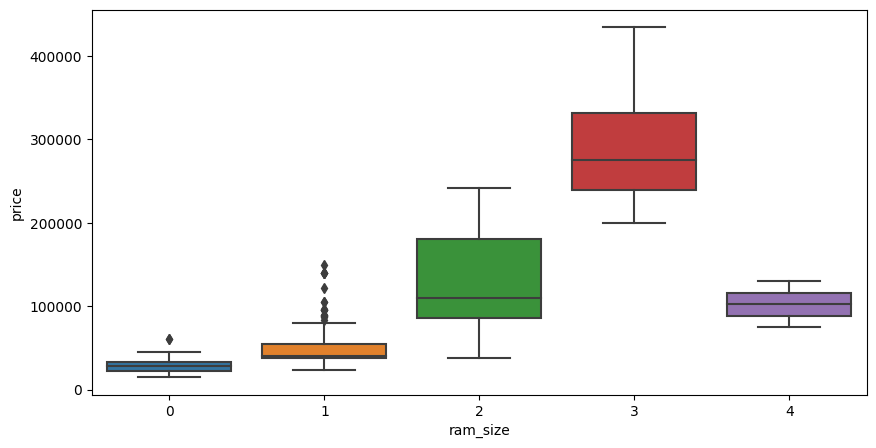

In [19]:
plt.figure(figsize=(10, 5))
sns.boxplot(x = df.ram_size, y = df.price);

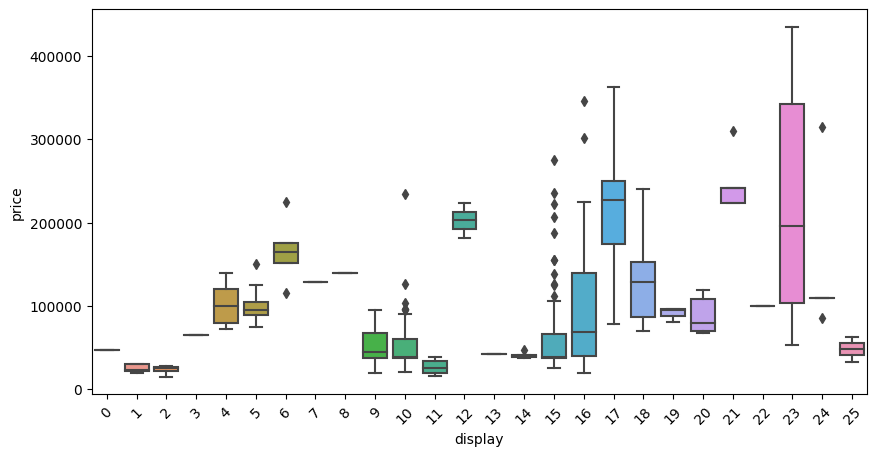

In [20]:
plt.figure(figsize=(10, 5))
ax = sns.boxplot(x = df.display, y = df.price)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

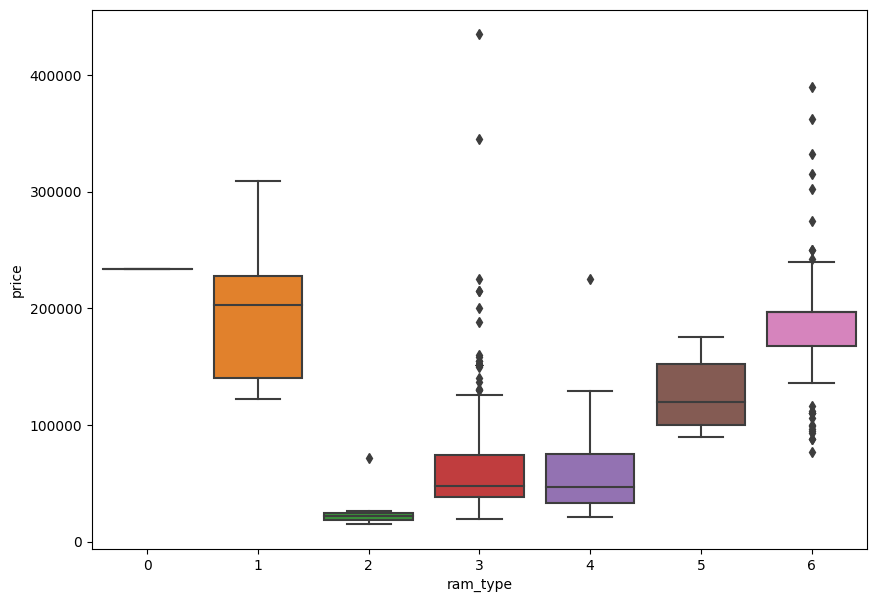

In [21]:
plt.figure(figsize=(10, 7))
sns.boxplot(x = df.ram_type, y = df.price);

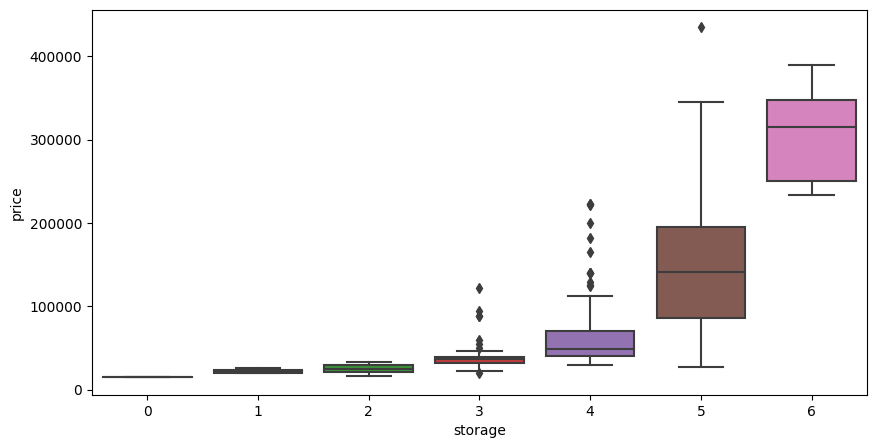

In [22]:
plt.figure(figsize=(10, 5))
sns.boxplot(x = df.storage, y = df.price);

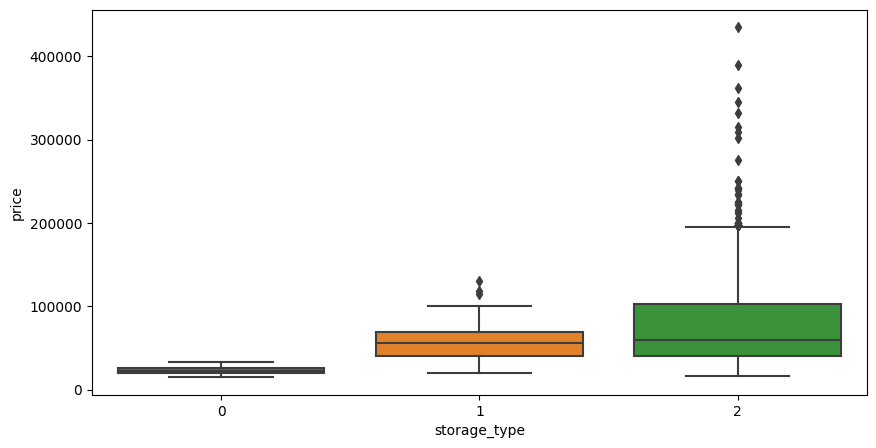

In [23]:
plt.figure(figsize=(10, 5))
sns.boxplot(x = df.storage_type, y = df.price);

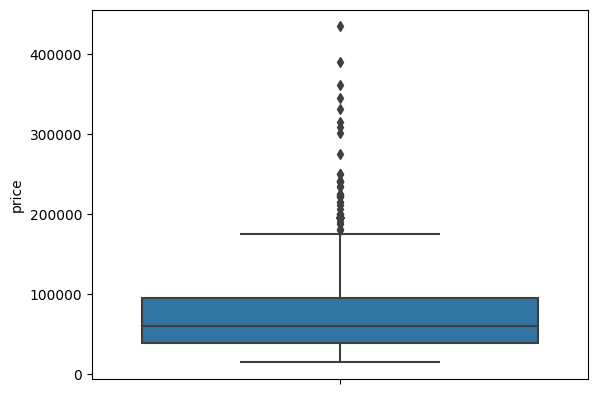

In [24]:
sns.boxplot(y=df["price"]);

In [25]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 720    │ │ int32       │ 7     │                                                          │
│ │ Number of columns │ 8      │ │ float64     │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃ column_name       ┃ NA   ┃ NA %   ┃ mean     ┃ sd      ┃ p0      ┃ p25     ┃ p75     ┃ p100     ┃ hist     ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩  │
│ │ price             │    0 │      0 │    82000 │   62000 │   15000 │   39000 │   95000 │   430000 │   █▂▁    │  │
│ │ ram_size          │    0 │      0 │      1.4 │    0.63 │       0 │       1 │       2 │        4 │   ▁█ ▅   │  │
│ │ ram_type          │    0 │      0 │      3.4 │     1.1 │       0 │       3 │       3 │        6 │     █▁▁  │  │
│ │ processor         │    0 │      0 │       16 │     5.7 │       0 │      13 │      21 │       25 │  ▁▂▃▆▅█  │  │
│ │ storage           │    0 │      0 │      4.1 │    0.79 │       0 │       4 │       5 │        6 │     ▂█▅  │  │
│ │ storage_type      │    0 │      0 │      1.9 │    0.34 │       0 │       2 │       2 │        2 │     ▁ █  │  │
│ │ os_type           │    0 │      0 │      3.7 │    0.64 │       0 │       4 │       4 │        4 │      ▂█  │  │
│ │ display           │    0 │      0 │       14 │     3.7 │       0 │      13 │      16 │       25 │     ▂█   │  │
│ └───────────────────┴──────┴────────┴──────────┴─────────┴─────────┴─────────┴─────────┴──────────┴──────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

## Take a look closely at the target variable, that is our price

In [26]:
print(f'The Mean Price is: {df.price.mean():.2f}')
print('-----------------------------------------')

print('The Median Price is:', df.price.median())
print('******************************************')

print(f'The Standard Deviation of Price is: {df.price.std():.2f}')
print('------------------------------------------')

print('The 90th Quantile Price is:', df.price.quantile(.90))
print('******************************************')

print('The Minimum Price is:', df.price.min())
print('--------------------------------------------')

print('The Maximum Price is:', df.price.max())
print('******************************************')

The Mean Price is: 81605.84
-----------------------------------------
The Median Price is: 59990.0
******************************************
The Standard Deviation of Price is: 61552.96
------------------------------------------
The 90th Quantile Price is: 194990.0
******************************************
The Minimum Price is: 14990.0
--------------------------------------------
The Maximum Price is: 434830.0
******************************************


From the above stats, it's clear that our mean laptop price is 81k which is between the 14k min and 194k max prices. The standard deviation isn't well spread and the data isn't normally distrubted. This indicates there is outlier in our price data. We will visually check the price data to confrim our assumption.

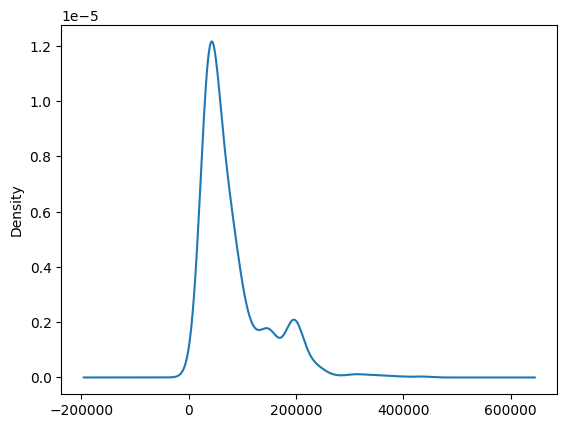

In [27]:
df.price.plot(kind='kde');

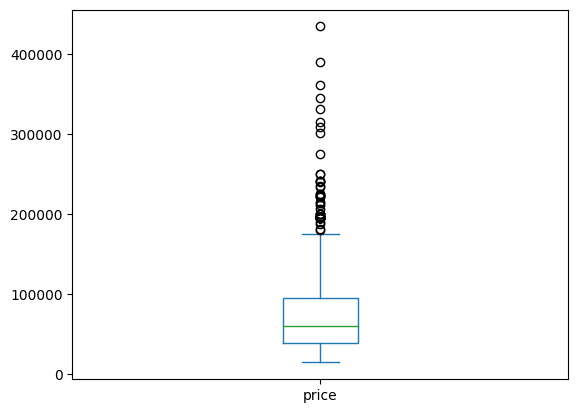

In [28]:
df.price.plot(kind='box');

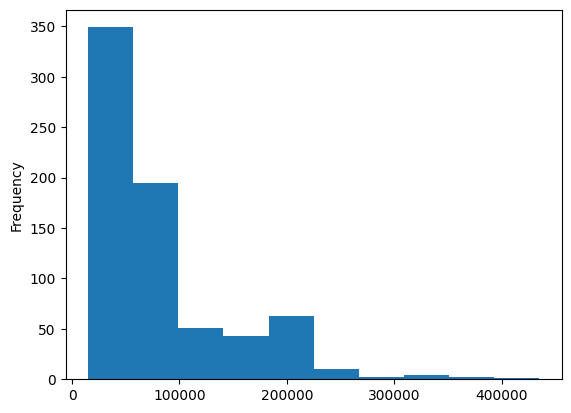

In [29]:
df.price.plot(kind='hist');

We see that half of laptops are sold in the range of 5000 to 100000, relatively, people spend less than 3000000 on laptops while very few spend between 300000 and above. We won't touch or remove the outliers since Elon didn't give a clear instruction on that. The price data stays like that but will log transform the data.

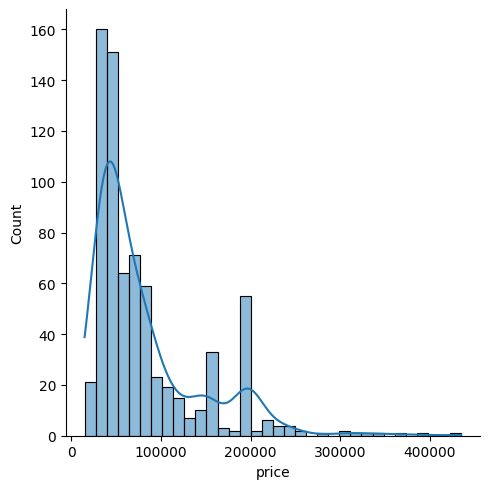

In [30]:
sns.displot(df.price, kde = True);

In [31]:
# Split the data into X and y
X = df.drop('price', axis=1)
y = np.log(df['price'])

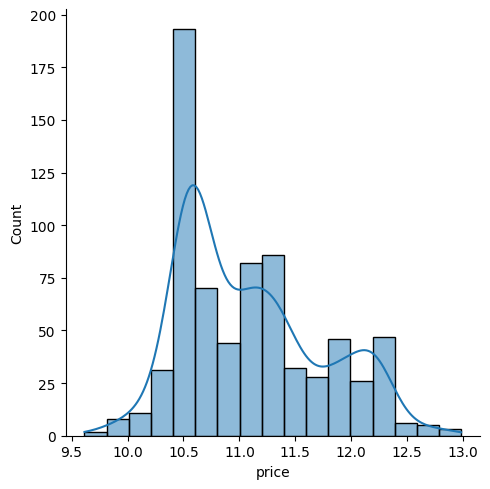

In [32]:
# The log transform didn't do quite well since it is skewed to the left
sns.displot(y, kde = True);

In [33]:
# Split the dataset into 70% train set and 30% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [34]:
# Check the shape
print(X_train.shape), print(X_test.shape), print(y_train.shape), print(y_test.shape)

(504, 7)
(216, 7)
(504,)
(216,)


(None, None, None, None)

## Model Training

We will use three models, Linear regression, Grandiant Boosting Regressor and Random Forest to train our dataset for prediction

In [35]:
models = {
    'Linear Regression': LinearRegression(),
    'Gbr': GradientBoostingRegressor(),
    'Rfr': RandomForestRegressor()
}

def fit_and_score(models, X_train, X_test, y_train, y_test):
    '''
    Fits and evaluates given machine learning models.
    models : a dictionary of different Scikit-Learn or XGBoost machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : testing labels
    '''
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores = {}
    # loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Make predictions with the trained model
        y_pred = model.predict(X_test)
        # Calculate model evaluation metrics
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        # Add the model evaluation metrics to the model_scores dictionary
        model_scores[name] = {'R2_score': r2, 'MSE': mse, 'MAE': mae, 'RMSE': rmse}
    return model_scores


In [36]:
model_scores = fit_and_score(models, X_train, X_test, y_train, y_test)

print(model_scores)

{'Linear Regression': {'R2_score': 0.7749943440591138, 'MSE': 0.08481389611497414, 'MAE': 0.23036667327909846, 'RMSE': 0.29122825432120103}, 'Gbr': {'R2_score': 0.9188351118207883, 'MSE': 0.03059438824072807, 'MAE': 0.12568552776533753, 'RMSE': 0.17491251596363272}, 'Rfr': {'R2_score': 0.9105123031391513, 'MSE': 0.03373159751645673, 'MAE': 0.11461677277195216, 'RMSE': 0.1836616386632133}}


## Model Comparison

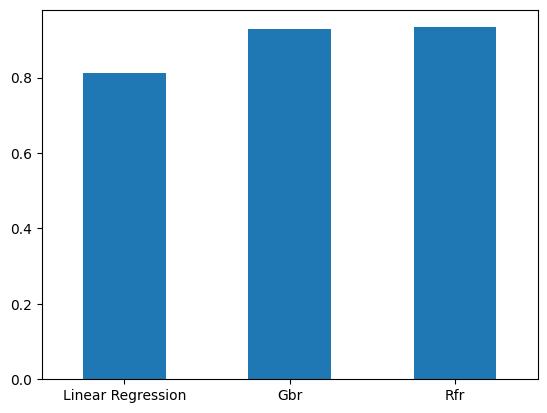

In [37]:
model_scores = {'Linear Regression': 0.8125459420983552,
                'Gbr': 0.9277935102441893,
                'Rfr': 0.9331637948525595}

scores_series = pd.Series(model_scores)
scores_series.plot.bar(rot=0);

All three model did well but we will use the model that gave us the highest R2 score and the lowest error, which is `GradientBoostingRegressor() model`. Next we will hypertune the model with both Grid and Random SearchCV and retrain with the best parameters to see if we can get a better score and lower error.

## Hyperparameter Tuning

In [38]:
# GridSearchCV for GradientBoostingRegressor
gbr_reg_grid = {'learning_rate': [0.05, 0.1, 0.15],
                'max_depth': [3, 4, 5],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': [None, 'sqrt', 'log2'],
                'n_estimators': [100, 200, 300]}



# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for GradientBoostingRegressor
gbr_grid = GridSearchCV(GradientBoostingRegressor(), 
                        param_grid = gbr_reg_grid,
                        cv=5,
                        n_jobs=-1,
                        verbose=True)

# Fit random hyperparameter search model for GradientBoostingRegressor()
gbr_grid.fit(X_train, y_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.15],
                         'max_depth': [3, 4, 5],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=True)

In [39]:
print(" Results from GridSearchCV " )
print("\n The best parameters:\n", gbr_grid.best_params_)
print("\n The best score:\n", gbr_grid.best_score_)

 Results from GridSearchCV 

 The best parameters:
 {'learning_rate': 0.15, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

 The best score:
 0.9230637495450115


In [40]:
GridModel = GradientBoostingRegressor(learning_rate=0.15, max_features='sqrt', max_depth=4, n_estimators=100, min_samples_split=2, min_samples_leaf = 2)
GridModel.fit(X_train,y_train)

GradientBoostingRegressor(learning_rate=0.15, max_depth=4, max_features='sqrt',
                          min_samples_leaf=2)

In [41]:
y_pred_grid =GridModel.predict(X_test)

In [42]:
# evaluate the model
mse = mean_squared_error(y_test, y_pred_grid)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_grid)
mae = mean_absolute_error(y_test, y_pred_grid)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("R-squared: ", r2)

MSE:  0.026662780701183286
RMSE:  0.16328741746130743
R-squared:  0.9292654065467634


In [43]:
# RandomizedSearchCV for GradientBoostingRegressor
gbr_reg_rs = {'learning_rate': [0.05, 0.1, 0.15],
              'max_depth': [3, 4, 5],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': [None, 'sqrt', 'log2'],
              'n_estimators': [100, 200, 300]}



# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for GradientBoostingRegressor
gbr_rs = RandomizedSearchCV(GradientBoostingRegressor(),
                            param_distributions = gbr_reg_rs,
                            cv=5,
                            n_jobs=-1,
                            n_iter=20,
                            verbose=True)

# Fit random hyperparameter search model for GradientBoostingRegressor()
gbr_rs.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.15],
                                        'max_depth': [3, 4, 5],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   verbose=True)

In [44]:
print(" Results from RandomSearchCV " )
print("\n The best parameters:\n", gbr_rs.best_params_)
print("\n The best score:\n", gbr_rs.best_score_)

 Results from RandomSearchCV 

 The best parameters:
 {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 4, 'learning_rate': 0.05}

 The best score:
 0.920035309188622


In [45]:
rsModel = GradientBoostingRegressor(learning_rate=0.05, max_depth=4, n_estimators=200,max_features='log2', min_samples_split=5, min_samples_leaf=2)
rsModel.fit(X_train,y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=4, max_features='log2',
                          min_samples_leaf=2, min_samples_split=5,
                          n_estimators=200)

In [46]:
y_pred_rs = rsModel.predict(X_test)

In [47]:
# evaluate the model
mse = mean_squared_error(y_test, y_pred_rs)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_rs)
mae = mean_absolute_error(y_test, y_pred_rs)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("R-squared: ", r2)

MSE:  0.027550719202497825
RMSE:  0.16598409322130186
R-squared:  0.9269097644400429


There is no much difference between the GridSearchCV and RandomSearchCV results. However, GridSearchCV will be saved for our streamlit app since the error is lower by a point.

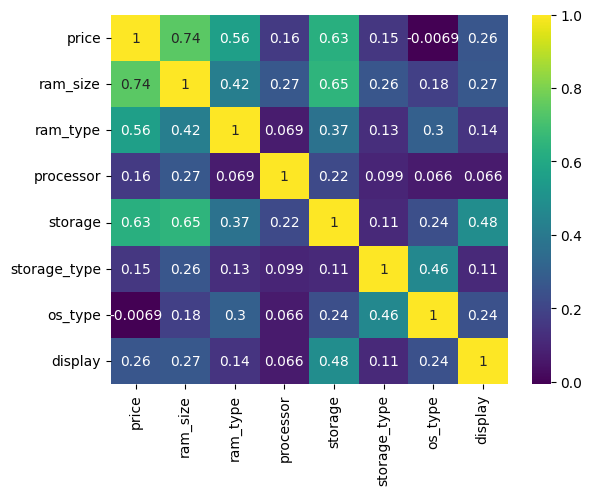

In [48]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Plot a heatmap of the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='viridis')

# Show the plot
plt.show()

The correlation matrix reveals that the ram_size and storage has strong and postive relationship with price while the type of operating system (os_type), display and storage type has low correlations with price. The future importance confirms this.

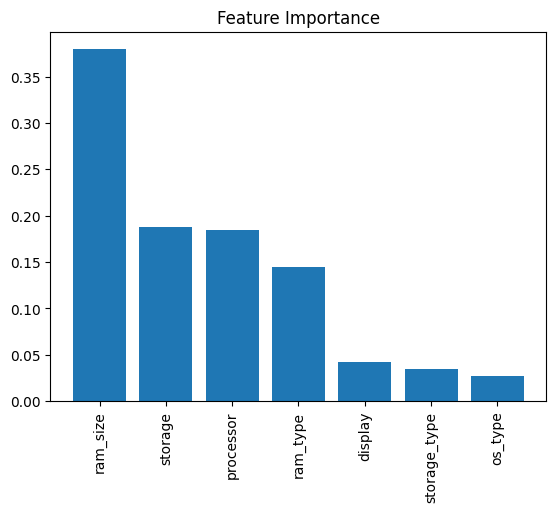

In [49]:
# Get the feature importances
feature_importances = rsModel.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X.shape[1]), feature_importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)

# Show plot
plt.show()

In [50]:
# Save the data for the dashboard in streamlit
df.to_csv("df.csv", index=False)

In [51]:
# Save the model
joblib.dump(GridModel,'model.pkl')

['model.pkl']

In [52]:
print(type(rsModel))

<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>


In [53]:
laptopdict

[{'4 GB': 0, '8 GB': 1, '16 GB': 2, '32 GB': 3, '128 GB': 4},
 {'LPDDR3': 0,
  'Unified Memory': 1,
  'LPDDR4': 2,
  'DDR4': 3,
  'LPDDR4X': 4,
  'LPDDR5': 5,
  'DDR5': 6},
 {'AMD Athlon Dual Core Processor': 0,
  'AMD Dual Core Processor': 1,
  'Intel Celeron Dual Core Processor': 2,
  'Intel Celeron Quad Core Processor': 3,
  'Intel Pentium Quad Core Processor': 4,
  'Intel Pentium Silver Processor': 5,
  'AMD Ryzen 3 Dual Core Processor': 6,
  'AMD Ryzen 3 Quad Core Processor': 7,
  'AMD Ryzen 3 Hexa Core Processor': 8,
  'AMD Ryzen 5 Dual Core Processor': 9,
  'AMD Ryzen 5 Quad Core Processor': 10,
  'AMD Ryzen 5 Hexa Core Processor': 11,
  'AMD Ryzen 7 Quad Core Processor': 12,
  'AMD Ryzen 7 Octa Core Processor': 13,
  'AMD Ryzen 9 Octa Core Processor': 14,
  'Apple M1 Processor': 15,
  'Apple M1 Pro Processor': 16,
  'Apple M1 Max Processor': 17,
  'Apple M2 Processor': 18,
  'Intel Core i3 Processor': 19,
  'Intel OptaneIntel Core i3 Processor': 20,
  'Intel Core i5 Processor':

In [54]:
import json

with open('laptopdict.json', 'w') as f:
    json.dump(laptopdict, f)
f.close()

In [55]:
laptopdict[5].values()

dict_values(['Chrome', 'DOS', 'Mac OS', 'Windows 10', 'Windows 11'])